<a href="https://colab.research.google.com/github/lucaspalomeque/ctf_trades_binance/blob/master/ETL_Trades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ETLs Trades#

Temas a solucionar: 
1. Bitstamp problemas con el almacenamiento
2. Kraken problema con el timestamp (lo lleva a 1970)
3. Binance no corre bien los dollar bars. 
4. Agregar en la transformacion el tickey y el exchange. Si todos los datos se almacenan igual con un regex podriamos agregar eso facilmente. 
5. Sumar CUSUM filter
6. Crear imbalance Bars

In [0]:
%pip install ijson
%pip install json

import json  
import pandas as pd  
from pandas.io.json import json_normalize  

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

import numpy as np

import datetime

  ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [0]:
#esto es el codigo para subir cosas a google colab
def subir_archivo():
  from google.colab import files
  uploaded = files.upload()
  
  for file in uploaded.keys():
    print('Uploaded file "{name}" with length {length} bytes'.format(name=file, length=len(uploaded[file])))
  
  return uploaded

In [0]:
subir_archivo()

Saving kraken-BTCUSD-2019-5-13 07_58_54.json to kraken-BTCUSD-2019-5-13 07_58_54.json
Uploaded file "kraken-BTCUSD-2019-5-13 07_58_54.json" with length 64538 bytes


{'kraken-BTCUSD-2019-5-13 07_58_54.json': b'{"data":[{"price":"7073.70000","volume":"0.10000000","time":"1557730746.807457","side":"b","orderType":"m","misc":""},{"price":"7073.60000","volume":"0.06180000","time":"1557730778.637459","side":"b","orderType":"l","misc":""},{"price":"7074.70000","volume":"0.15000000","time":"1557730788.577943","side":"b","orderType":"m","misc":""},{"price":"7073.50000","volume":"0.00461000","time":"1557730804.497243","side":"s","orderType":"m","misc":""},{"price":"7073.50000","volume":"0.01316000","time":"1557730809.804852","side":"s","orderType":"m","misc":""},{"price":"7074.10000","volume":"0.09890000","time":"1557730810.847485","side":"b","orderType":"l","misc":""},{"price":"7074.80000","volume":"0.25000000","time":"1557730851.643384","side":"b","orderType":"l","misc":""},{"price":"7074.40000","volume":"0.30000000","time":"1557730861.593042","side":"s","orderType":"l","misc":""},{"price":"7074.40000","volume":"0.30000000","time":"1557730862.455507","sid

Modulo necesario para abrir el json con la data y poder llevarlo a dataframe. Segun lei con ijson se consigue algo mas eficiente. 

In [0]:
def abrir_trades(name):
  import json  
  import pandas as pd  
  from pandas.io.json import json_normalize  


  
  with open(name) as f: 
      d = json.load(f) 
    
  trades = json_normalize(d['data']) 

  return trades

In [0]:
trades = abrir_trades('kraken-BTCUSD-2019-5-13 07_58_54.json')

In [0]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 6 columns):
misc         592 non-null object
orderType    592 non-null object
price        592 non-null object
side         592 non-null object
time         592 non-null object
volume       592 non-null object
dtypes: object(6)
memory usage: 27.8+ KB


In [0]:
trades.head()

,misc,orderType,price,side,time,volume
0,,m,7073.70000,b,1557730746.807457,0.10000000
1,,l,7073.60000,b,1557730778.637459,0.06180000
2,,m,7074.70000,b,1557730788.577943,0.15000000
3,,m,7073.50000,s,1557730804.497243,0.00461000
4,,m,7073.50000,s,1557730809.804852,0.01316000


In [0]:
trades = kraken_transformacion(trades,'price','volume','time')

def para transformar los datos de hitbtc en las diferentes formas que necesitamos

In [0]:
def kraken_transformacion(df,price_column,volume_column,time_column):
  # HAY UN PROBLEMA EN KRAKEN A LA HORA DE PASAR EL TIMESTAMP, lo manda a 1970
  df[time_column] = pd.to_datetime(df[time_column], unit='ns')
  #df[time_column] = pd.to_datetime(trades[time_column])
  
  df.rename(columns={volume_column:'volume',time_column:'timestamp'},inplace=True)
  
  df[price_column] = df[price_column].astype(float)
  df['volume'] = df['volume'].astype(float)
  
  return df

In [0]:
def hitbtc_transformacion(df,time_column,price_column,volume_column):
  df[time_column] = df[time_column].map(lambda x: x.replace('T', ' ').rstrip("Z"))
  df[time_column] = pd.to_datetime(trades[time_column])
  
  df.rename(columns={volume_column:'volume'},inplace=True)
  
  df[price_column] = df[price_column].astype(float)
  df['volume'] = df['volume'].astype(float)
  
  return df

In [0]:
def bitfinex_transformacion(df,time_column,price_column,volume_column):
  df[time_column] = pd.to_datetime(df[time_column], unit='ms')
  trades.rename(columns={'amount':'volume','timeStamp':'timestamp'},inplace=True)

  return df

In [0]:
def binance_transformacion(df):
  
  df.rename(columns={'E':'Event time','T':'timestamp','p':'price',
                         'q':'volume','M':'Ignore','a':'Seller order ID',
                         'b':'Buyer order ID','e':'event type','m':'MM Buyer','s':'Symbol','t':'Trade ID'}, inplace=True)


  trades.drop(['Ignore'],axis=1,inplace=True)
  trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms')
  trades['Event time']=pd.to_datetime(trades['Event time'], unit='ms')
  trades['price'] = trades['price'].astype(float)
  trades['volume'] = trades['volume'].astype(float)
  
  return trades

In [0]:
trades = binance_transformacion(trades)

In [0]:
def trades_timestamp(df):
  #a todas las columnas de ahora mas el tiempo es timestamp
  tradesT=df.set_index(df['timestamp'])
  
  #sirve ver este retorno? o solo tomamos el de las OHLCs. Porque? 
  tradesT['retorno']= tradesT['price'] / tradesT['price'].shift(1) - 1
  return tradesT
  

In [0]:
tradesT = trades_timestamp(trades)

In [0]:
tradesT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8075 entries, 2019-05-09 23:51:51.539000 to 2019-05-10 00:51:48.428000
Data columns (total 11 columns):
Event time         8075 non-null datetime64[ns]
timestamp          8075 non-null datetime64[ns]
Seller order ID    8075 non-null int64
Buyer order ID     8075 non-null int64
event type         8075 non-null object
MM Buyer           8075 non-null bool
price              8075 non-null float64
volume             8075 non-null float64
Symbol             8075 non-null object
Trade ID           8075 non-null int64
retorno            8074 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(3), int64(3), object(2)
memory usage: 861.8+ KB


In [0]:
class BarSeries(object):
    '''
        Clase Base para resamplear dataframe de trades a un OHLC(V)
        usando diferentes esquemas. Este esquema en particular
        implementa el basico de time bars
    '''
    
    #inicializacion del programa
    def __init__(self, df, datetimecolumn = 'DateTime'):
        self.df = df
        self.datetimecolumn = datetimecolumn
    
    #crear columnas de OHLC, tenemos que pasarle el nombre de la columna y freq
    def process_column(self, column_name, frequency):
        return self.df[column_name].resample(frequency, label='right').ohlc()
    
    def process_volume(self, column_name, frequency):
        return self.df[column_name].resample(frequency, label='right').sum()
    
    def process_ticks(self, price_column = 'price', volume_column = 'volume', frequency = '1Min'):
        price_df = self.process_column(price_column, frequency)
        volume_df = self.process_volume(volume_column, frequency)
        price_df['volume'] = volume_df
        return price_df

In [0]:
# inicializo la serie
ohlc=BarSeries(tradesT)

#testeo las defs ya en la clase
OHLC=ohlc.process_column('price',"300S")
VOL=ohlc.process_volume('volume','300S')

#seteo las bars
time_bars=ohlc.process_ticks(frequency="300S")

In [0]:
time_bars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2019-05-09 23:55:00 to 2019-05-10 00:55:00
Freq: 300S
Data columns (total 5 columns):
open      13 non-null float64
high      13 non-null float64
low       13 non-null float64
close     13 non-null float64
volume    13 non-null float64
dtypes: float64(5)
memory usage: 624.0 bytes


In [0]:
class TickBarSeries(BarSeries):
    '''
        Class for generating tick bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'timestamp', volume_column = 'volume'):
        self.volume_column = volume_column
        super(TickBarSeries, self).__init__(df, datetimecolumn)
    
    def process_column(self, column_name, frequency):
        res = []
        for i in range(frequency, len(self.df), frequency):
            sample = self.df.iloc[i-frequency:i]
            v = sample[self.volume_column].values.sum()
            o = sample[column_name].values.tolist()[0]
            h = sample[column_name].values.max()
            l = sample[column_name].values.min()
            c = sample[column_name].values.tolist()[-1]
            d = sample.index.values[-1]
            
            res.append({
                self.datetimecolumn: d,
                'open': o,
                'high': h,
                'low': l,
                'close': c,
                'volume': v
            })

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res

    
    def process_ticks(self, price_column = 'price', volume_column = 'volume', frequency = 10):
        price_df = self.process_column(price_column, frequency)
        return price_df    

In [0]:
ohlc_ticks=TickBarSeries(tradesT)

#notar que los aca la frecuencia la pongo en 100 no en Seg ni Min pq son cantidad de trades
ohlc_col_ticks = ohlc_ticks.process_column('price',100)
ticks_bars=ohlc_ticks.process_ticks(frequency=100)


In [0]:
ticks_bars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2019-05-09 23:54:06.538000 to 2019-05-10 00:51:16.624000
Data columns (total 5 columns):
close     80 non-null float64
high      80 non-null float64
low       80 non-null float64
open      80 non-null float64
volume    80 non-null float64
dtypes: float64(5)
memory usage: 3.8 KB


In [0]:
#esta no funciono del todo bien como me gustaria.
class VolumeBarSeries(BarSeries):
    '''
        Class for generating volume bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'timestamp', volume_column = 'volume'):
        self.volume_column = volume_column
        super(VolumeBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf = []
        start_index = 0.
        volume_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            
            buf.append(pi)
            volume_buf += vi
            
            if volume_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,  
                    'volume': volume_buf
                })
                
                buf, volume_buf = [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res
    
    def process_ticks(self, price_column = 'price', volume_column = 'volume', frequency = 1000):
        price_df = self.process_column(price_column, frequency)
        return price_df 

In [0]:
volume_df = VolumeBarSeries(tradesT)
volume_bars = volume_df.process_ticks(frequency=1000)

In [0]:
volume_bars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2019-05-09 23:53:36.997000 to 2019-05-10 00:51:28.178000
Data columns (total 5 columns):
close     144 non-null float64
high      144 non-null float64
low       144 non-null float64
open      144 non-null float64
volume    144 non-null float64
dtypes: float64(5)
memory usage: 6.8 KB


In [0]:
class DollarBarSeries(BarSeries):
    '''
        Class for generating "dollar" bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'timestamp', volume_column = 'volume'):
        self.volume_column = volume_column
        super(DollarBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf, vbuf = [], []
        start_index = 0.
        dollar_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            
            dvi = pi * vi
            buf.append(pi)
            vbuf.append(vi)
            dollar_buf += dvi
            
            if dollar_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                v = np.sum(vbuf)
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,
                    'volume': v,
                    'dollar': dollar_buf
                })
                
                buf, vbuf, dollar_buf = [], [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res 
    
    def process_ticks(self, price_column = 'price', volume_column = 'volume', frequency = 1000):
        price_df = self.process_column(price_column, frequency)
        return price_df    
    

In [0]:
#problemas para correrlo con Binance 

dolar_df = DollarBarSeries(tradesT)
#dolar_df_cols=dolar_df.process_column('price',100000)
dollar_bars = dolar_df.process_ticks(frequency=10000)

In [0]:
dollar_bars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 2019-05-10 15:55:44.410000 to 2019-05-10 16:40:27.403000
Data columns (total 6 columns):
close     220 non-null float64
dollar    220 non-null float64
high      220 non-null float64
low       220 non-null float64
open      220 non-null float64
volume    220 non-null float64
dtypes: float64(6)
memory usage: 12.0 KB


In [0]:
def ploteo_comparacion_bars(df_trades,df_time,df_ticks,df_dollars): 
  plt.figure(figsize = (18, 8))
  plt.title('Bars sobre los precios')
  plt.plot(df_trades.index.values, df_trades.price.values, label = 'Raw prices', ls = '--', color = 'black')
  #plt.plot(df_time.index.values[:12], df_time.close.values[:12], ls = '', markersize = 10, marker = '.')
  plt.plot(df_ticks.index.values, df_ticks.close.values, ls = '',color='red', markersize = 4, marker = 'o', label = '350 ticks bars')
  #plt.plot(df_volume.index.values[:30], df_volume.close.values[:30], ls = '', markersize = 10, marker = '*', label = '10K volume bars')
  plt.plot(df_dollars.index.values, df_dollars.close.values, ls = '',color='orange', markersize = 8, marker = '*', label = '100K dollar bars ')

  for e, t in enumerate(df_time.index.values):
      if e == 0:
          plt.axvline(t, ls = '--', label = '5 Mins time bars')
      else:
          plt.axvline(t, ls = '--')

  plt.legend()
  
  return plt.show()
  

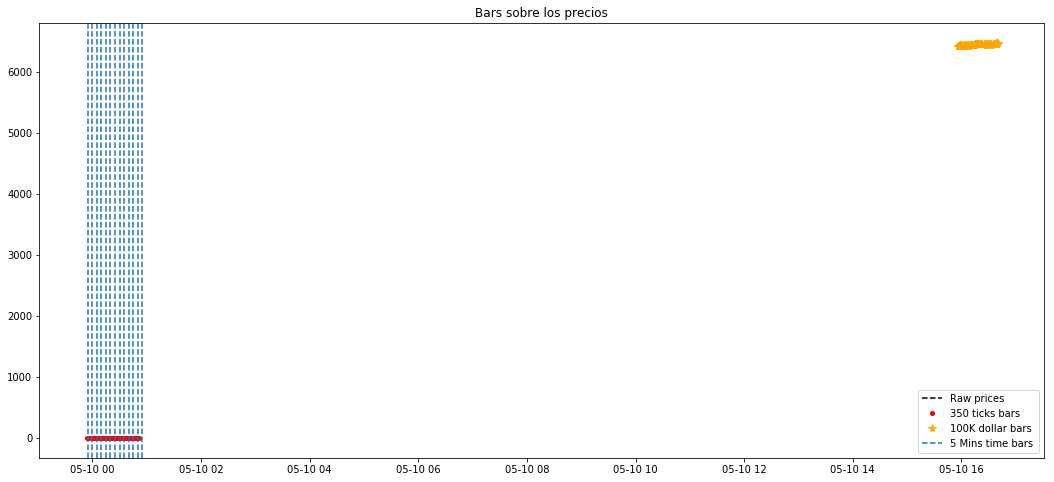

In [0]:
ploteo_comparacion_bars(tradesT,time_bars,ticks_bars,dollar_bars)

In [0]:
#esto todavia estoy tratando de entenderlo 
class ImbalanceTickBarSeries(BarSeries):
    '''
        Clase para generar series de imbalance tick bars
    '''
    def __init__(self, df, datetimecolumn = 'timestamp', volume_column = 'volume'):
        self.volume_column = volume_column
        super(ImbalanceTickBarSeries, self).__init__(df, datetimecolumn)
        
    def get_bt(self, data):
        s = np.sign(np.diff(data))
        for i in range(1, len(s)):
            if s[i] == 0:
                s[i] = s[i-1]
        return s

    def get_theta_t(self, bt):
        return np.sum(bt)

    def ewma(self, data, window):

        alpha = 2 /(window + 1.0)
        alpha_rev = 1-alpha

        scale = 1/alpha_rev
        n = data.shape[0]

        r = np.arange(n)
        scale_arr = scale**r
        offset = data[0]*alpha_rev**(r+1)
        pw0 = alpha*alpha_rev**(n-1)

        mult = data*pw0*scale_arr
        cumsums = mult.cumsum()
        out = offset + cumsums*scale_arr[::-1]
        return out
               
    def process_column(self, column_name, initital_T = 100, min_bar = 10, max_bar = 1000):
        init_bar = self.df[:initital_T][column_name].values.tolist()

        ts = [initital_T]
        bts = [bti for bti in self.get_bt(init_bar)]  
        res = []

        buf_bar, vbuf, T = [], [], 0.
        for i in range(initital_T, len(self.df)):

 
            di = self.df.index.values[i]

            buf_bar.append(self.df[column_name].iloc[i])
            bt = self.get_bt(buf_bar)
            theta_t = self.get_theta_t(bt)

            try:
                e_t = self.ewma(np.array(ts), initital_T / 10)[-1]
                e_bt = self.ewma(np.array(bts), initital_T)[-1]
            except:
                e_t = np.mean(ts)
                e_bt = np.mean(bts)
            finally:                   
                if np.isnan(e_bt):
                    e_bt = np.mean(bts[int(len(bts) * 0.9):])
                if np.isnan(e_t):
                    e_t = np.mean(ts[int(len(ts) * 0.9):])

                
            condition = np.abs(theta_t) >= e_t * np.abs(e_bt)

            
            if (condition or len(buf_bar) > max_bar) and len(buf_bar) >= min_bar:

                o = buf_bar[0]
                h = np.max(buf_bar)
                l = np.min(buf_bar)
                c = buf_bar[-1]
                v = np.sum(vbuf)
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,
                    'volume': v
                })
                
                ts.append(T)
                for b in bt:
                    bts.append(b) 
                    
                buf_bar = []
                vbuf = []
                T = 0.           
            else:
                vbuf.append(self.df[self.volume_column].iloc[i])
                T += 1

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res 
    
    def process_ticks(self, price_column = 'price', volume_column = 'volume', init = 100, min_bar = 10, max_bar = 1000):
        price_df = self.process_column(price_column, init, min_bar, max_bar)
        return price_df  